<a href="https://colab.research.google.com/github/hukim1112/one-day-DL/blob/main/(pytorch)MPG_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 자동차 연비 예측하기: 회귀

*회귀*(regression)는 가격이나 확률 같이 연속된 출력 값을 예측하는 것이 목적입니다. 이와는 달리 *분류*(classification)는 여러개의 클래스 중 하나의 클래스를 선택하는 것이 목적입니다(예를 들어, 사진에 사과 또는 오렌지가 포함되어 있을 때 어떤 과일인지 인식하는 것).

이 노트북은 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) 데이터셋을 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델을 만듭니다. 이 기간에 출시된 자동차 정보를 모델에 제공하겠습니다. 이 정보에는 실린더 수, 배기량, 마력(horsepower), 공차 중량 같은 속성이 포함됩니다.

In [ ]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

!pip install torchmetrics

## Auto MPG 데이터셋

이 데이터셋은 [UCI 머신 러닝 저장소](https://archive.ics.uci.edu/ml/)에서 다운로드할 수 있습니다.

### 데이터 구하기
먼저 데이터셋을 다운로드합니다.

In [16]:
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

판다스를 사용하여 데이터를 읽습니다.

In [17]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(data_url, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 데이터 정제하기

이 데이터셋은 일부 데이터가 누락되어 있습니다.

In [18]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

문제를 간단하게 만들기 위해서 누락된 행을 삭제하겠습니다.

In [19]:
dataset = dataset.dropna()

`"Origin"` 열은 수치형이 아니고 범주형이므로 원-핫 인코딩(one-hot encoding)으로 변환하겠습니다:

In [20]:
origin = dataset.pop('Origin')

In [21]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### 데이터셋을 훈련 세트와 테스트 세트로 분할하기

이제 데이터를 훈련 세트와 테스트 세트로 분할합니다.

테스트 세트는 모델을 최종적으로 평가할 때 사용합니다.

In [22]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [23]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### 특성과 레이블 분리하기

특성에서 타깃 값 또는 "레이블"을 분리합니다. 이 레이블을 예측하기 위해 모델을 훈련시킬 것입니다.

In [24]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### 데이터 정규화

위 `train_stats` 통계를 다시 살펴보고 각 특성의 범위가 얼마나 다른지 확인해 보죠.

특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장됩니다. 특성을 정규화하지 않아도 모델이 *수렴할 수 있지만*, 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어집니다.

노트: 의도적으로 훈련 세트만 사용하여 통계치를 생성했습니다. 이 통계는 테스트 세트를 정규화할 때에도 사용됩니다. 이는 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위해서입니다.

In [25]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

정규화된 데이터를 사용하여 모델을 훈련합니다.

주의: 여기에서 입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 원-핫 인코딩과 마찬가지로 모델에 주입되는 모든 데이터에 적용되어야 합니다. 여기에는 테스트 세트는 물론 모델이 실전에 투입되어 얻은 라이브 데이터도 포함됩니다.

In [26]:
train_labels.values.shape

(314,)

In [27]:
from torch.utils.data import TensorDataset, DataLoader
#torch 데이터셋을 먼저 구축합니다.
train_dataset = TensorDataset(torch.tensor(normed_train_data.values, dtype=torch.float32), torch.tensor(train_labels.values.reshape(-1,1), dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(normed_test_data.values, dtype=torch.float32), torch.tensor(test_labels.values.reshape(-1,1), dtype=torch.float32))

In [28]:
#torch 데이터로더를 구축합니다. 배치사이즈는 512개, 학습셋은 shuffe해줍니다.
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

## 모델

### 모델 만들기

모델을 구성해 보죠. 여기에서는 두 개의 완전 연결(densely connected) 은닉층으로 `Sequential` 모델을 만들겠습니다. 출력 층은 하나의 연속적인 값을 반환합니다.

In [29]:
from torch import nn

class MPGregression(nn.Module):
    def __init__(self, input_dims):
        super().__init__()
        self.fcn = nn.Sequential(
            nn.Linear(input_dims, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        y = self.fcn(x)
        return y

[torchmetrics](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)의 metric api를 사용해서 예측과 정답으로 accuracy나 mse, mae 등을 쉽게 계산하고, 그들의 누적값을 계산할 수 있습니다.

In [30]:
from torchmetrics import MeanSquaredError, MeanAbsoluteError

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

def train_epoch(dataloader, model, loss_fn, optimizer):
    mse  = MeanSquaredError().to(device)
    mae  = MeanAbsoluteError().to(device)
    model.train()
    total_loss, correct = 0, 0
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) #샘플과 정답을 GPU로 전달
        pred = model(X)
        loss = loss_fn(pred,y)
        mse(pred, y)
        mae(pred, y)

        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return mse.compute(), mae.compute()  #mse, mae

def test_epoch(dataloader, model, loss_fn):
    mse  = MeanSquaredError().to(device)
    mae  = MeanAbsoluteError().to(device)
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device) #샘플과 정답을 GPU로 전달
            pred = model(X)
            loss = loss_fn(pred,y)
            mse(pred, y)
            mae(pred, y)
    return mse.compute(), mae.compute()  #mse, mae

Using cuda device


### 모델 확인

모델의 구조를 확인합니다.

In [31]:
model = MPGregression(input_dims=normed_train_data.shape[-1])
model

MPGregression(
  (fcn): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

모델을 한번 실행해 보죠. 훈련 세트에서 `10` 샘플을 하나의 배치로 만들어 모델 결과를 호출해 보겠습니다.

In [32]:
example_batch = normed_train_data[:10]
model.eval()
pred = model.forward(torch.tensor(example_batch.values, dtype=torch.float32))

In [33]:
pred

tensor([[-0.2922],
        [-0.1746],
        [-0.1856],
        [-0.2900],
        [-0.2069],
        [-0.1946],
        [-0.2015],
        [-0.2138],
        [-0.1852],
        [-0.1543]], grad_fn=<AddmmBackward0>)

제대로 작동하는 것 같네요. 결괏값의 크기와 타입이 기대했던 대로입니다.

### 모델 훈련

이 모델을 1,000번의 에포크(epoch) 동안 훈련합니다.

In [34]:
epochs = 1000
train_mse = []
train_mae = []
val_mse = []
val_mae = []
loss_fn = nn.MSELoss()
model = model = MPGregression(input_dims=normed_train_data.shape[-1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    t_mse, t_mae = train_epoch(train_dataloader, model, loss_fn, optimizer)
    print(f"Train Error: \n Avg loss: {t_mse.item():>8f} \n")
    v_mse, v_mae = test_epoch(test_dataloader, model, loss_fn)
    print(f"Validation Error: \n Avg loss: {v_mse.item():>8f} \n")
    train_mse.append(t_mse.item()); train_mae.append(t_mae.item())
    val_mse.append(v_mse.item()); val_mae.append(v_mae.item())
print("Done!")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
-------------------------------
Train Error: 
 Avg loss: 4.683502 

Validation Error: 
 Avg loss: 4.991920 

Epoch 377
-------------------------------
Train Error: 
 Avg loss: 4.647340 

Validation Error: 
 Avg loss: 5.235004 

Epoch 378
-------------------------------
Train Error: 
 Avg loss: 4.752994 

Validation Error: 
 Avg loss: 5.123449 

Epoch 379
-------------------------------
Train Error: 
 Avg loss: 4.917100 

Validation Error: 
 Avg loss: 5.134961 

Epoch 380
-------------------------------
Train Error: 
 Avg loss: 4.723596 

Validation Error: 
 Avg loss: 5.230981 

Epoch 381
-------------------------------
Train Error: 
 Avg loss: 4.739481 

Validation Error: 
 Avg loss: 5.152831 

Epoch 382
-------------------------------
Train Error: 
 Avg loss: 4.618036 

Validation Error: 
 Avg loss: 5.096399 

Epoch 383
-------------------------------
Train Error: 
 Avg loss: 4.645387 

Validation Error: 
 Avg loss: 5.065780 

Epoch 384
------------

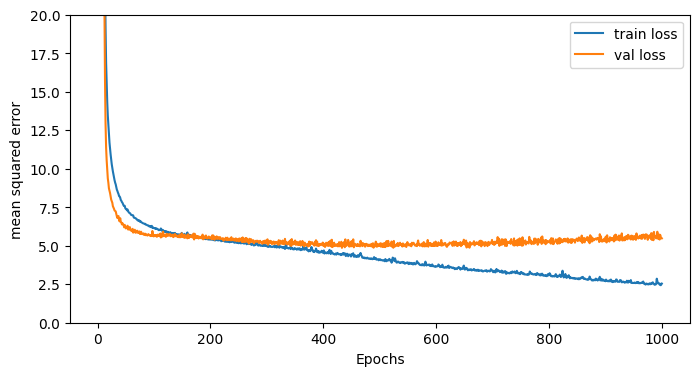

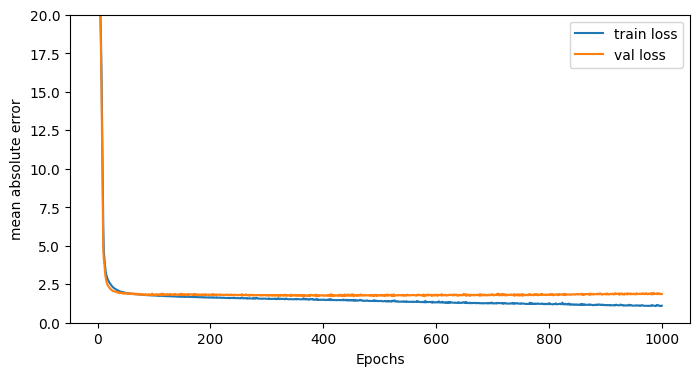

In [35]:
plt.figure(figsize=(8,4))
plt.xlabel("Epochs")
plt.ylabel("mean squared error")
plt.plot(list(range(1,len(train_mse)+1)), train_mse, label='train loss')
plt.plot(list(range(1,len(val_mse)+1)), val_mse, label='val loss')
plt.ylim([0,20])
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.xlabel("Epochs")
plt.ylabel("mean absolute error")
plt.plot(list(range(1,len(train_mae)+1)), train_mae, label='train loss')
plt.plot(list(range(1,len(val_mae)+1)), val_mae, label='val loss')
plt.ylim([0,20])
plt.legend()
plt.show()

이 그래프를 보면 수 백번 에포크를 진행한 이후에는 모델이 거의 향상되지 않는 것 같습니다. 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 만들어 보죠. 에포크마다 훈련 상태를 점검하기 위해 EarlyStopping 클래스를 만들어 사용하겠습니다. 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.

또한 시간에 따라 모델의 성능이 오히려 악화될 수 있으므로, 검증데이터 상 가장 좋은 성능을 보여준 모델의 체크포인트를 저장할 필요가 있습니다. EarlyStopping 내부에 best 모델을 저장하도록 구현했했습니다.

In [36]:
import numpy as np

class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [37]:
epochs = 1000
train_mse = [];train_mae=[]
val_mse = [];val_mae=[]
loss_fn = nn.MSELoss()
model = model = MPGregression(input_dims=normed_train_data.shape[-1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
ckpt_path = "./"
early_stopping = EarlyStopping(patience = 10, verbose = True, path=os.path.join(ckpt_path ,'best_checkpoint.pt'))


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    t_mse, t_mae = train_epoch(train_dataloader, model, loss_fn, optimizer)
    print(f"Train Error: \n Avg loss: {t_mse.item():>8f} \n")
    v_mse, v_mae = test_epoch(test_dataloader, model, loss_fn)
    print(f"Validation Error: \n Avg loss: {v_mse.item():>8f} \n")

    early_stopping(v_mse.item(), model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    train_mse.append(t_mse.item()); train_mae.append(t_mae.item())
    val_mse.append(v_mse.item()); val_mae.append(v_mae.item())
print("Done!")

Epoch 1
-------------------------------
Train Error: 
 Avg loss: 592.784485 

Validation Error: 
 Avg loss: 617.448181 

Validation loss decreased (inf --> 617.448181).  Saving model ...
Epoch 2
-------------------------------
Train Error: 
 Avg loss: 568.856506 

Validation Error: 
 Avg loss: 586.826599 

Validation loss decreased (617.448181 --> 586.826599).  Saving model ...
Epoch 3
-------------------------------
Train Error: 
 Avg loss: 535.124695 

Validation Error: 
 Avg loss: 541.904358 

Validation loss decreased (586.826599 --> 541.904358).  Saving model ...
Epoch 4
-------------------------------
Train Error: 
 Avg loss: 485.472839 

Validation Error: 
 Avg loss: 478.465088 

Validation loss decreased (541.904358 --> 478.465088).  Saving model ...
Epoch 5
-------------------------------
Train Error: 
 Avg loss: 417.748444 

Validation Error: 
 Avg loss: 394.863129 

Validation loss decreased (478.465088 --> 394.863129).  Saving model ...
Epoch 6
-----------------------------

저장된 학습로그를 사용해 모델의 훈련 과정을 시각화해 보겠습니다.

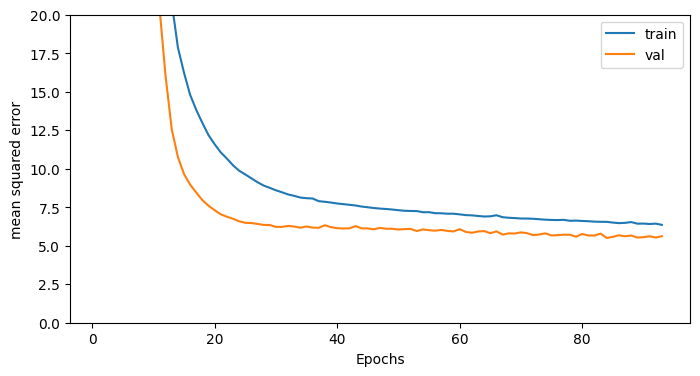

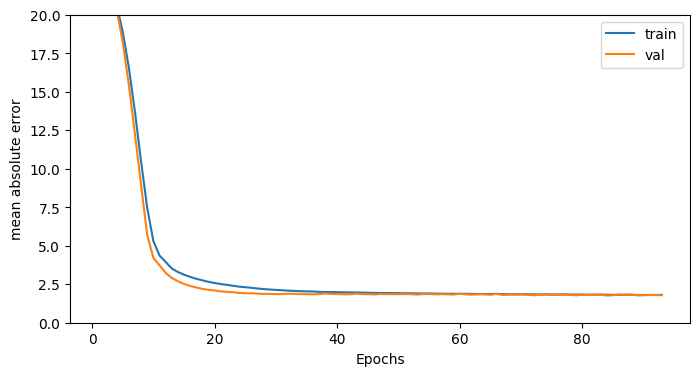

In [38]:
plt.figure(figsize=(8,4))
plt.xlabel("Epochs")
plt.ylabel("mean squared error")
plt.plot(list(range(1,len(train_mse)+1)), train_mse, label='train')
plt.plot(list(range(1,len(val_mse)+1)), val_mse, label='val')
plt.ylim([0,20])
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.xlabel("Epochs")
plt.ylabel("mean absolute error")
plt.plot(list(range(1,len(train_mae)+1)), train_mae, label='train')
plt.plot(list(range(1,len(val_mae)+1)), val_mae, label='val')
plt.ylim([0,20])
plt.legend()
plt.show()

이 그래프를 보면 검증 세트의 평균 오차가 약 +/- 2 MPG입니다. 좋은 결과인가요? 이에 대한 평가는 여러분에게 맡기겠습니다.

모델을 훈련할 때 사용하지 않았던 **테스트 세트**에서 모델의 성능을 확인해 보죠. 이를 통해 모델이 실전에 투입되었을 때 모델의 성능을 짐작할 수 있습니다:

## 예측

마지막으로 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측해 보겠습니다:

In [39]:
model = MPGregression(input_dims=9)
model.load_state_dict(torch.load("./best_checkpoint.pt"))
model.eval()

MPGregression(
  (fcn): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [40]:
test_predictions = model.forward(torch.tensor(normed_test_data.values, dtype=torch.float32)).flatten().detach().numpy()

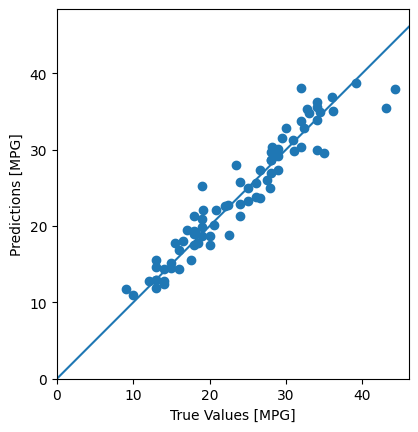

In [41]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


모델이 꽤 잘 예측한 것 같습니다. 오차의 분포를 살펴 보죠.

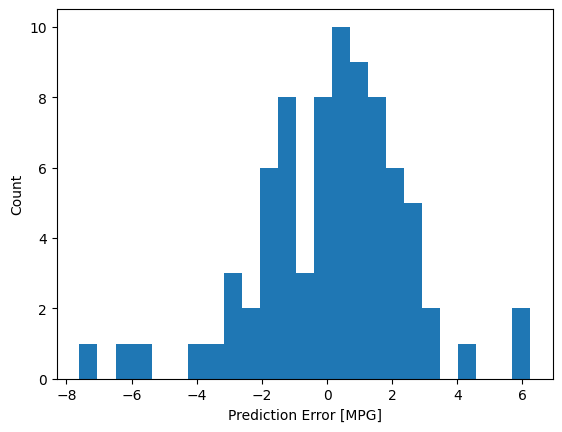

In [42]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

가우시안 분포가 아니지만 아마도 훈련 샘플의 수가 매우 작기 때문일 것입니다.

## 결론

이 노트북은 회귀 문제를 위한 기법을 소개합니다.

* 평균 제곱 오차(MSE)는 회귀 문제에서 자주 사용하는 손실 함수입니다(분류 문제에서 사용하는 손실 함수와 다릅니다).
* 비슷하게 회귀에서 사용되는 평가 지표도 분류와 다릅니다. 많이 사용하는 회귀 지표는 평균 절댓값 오차(MAE)입니다.
* 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 합니다.
* 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋습니다.
* 조기 종료(Early stopping)은 과대적합을 방지하기 위한 좋은 방법입니다.